# Preprocessing Training Dataset

This notebook constitutes the first pipeline of the N-Gram Language Modeling Analysis Project. It includes the preprocessing of the training data from the DUC 2005 dataset.

After the execution of this notebook, the following output files will be generated and saved in the folder /output_data:
- unknown_words.txt: List of words tagged as \<UNK\> during the preprocessing.
- used_words.txt: List of unique words after preprocessing.
- training_sentences.pkl: List of sentences in the training set after preprocessing, before tagging \<UNK\> words.
- training_sentences_unk.pkl: List of sentences in the training set after preprocessing, after tagging \<UNK\> words.
- unigram_dictionary_training.pkl: Dictionary containing all the unigrams of the training set after preprocessing.
- bigram_dictionary_training.pkl: Dictionary containing all the biigrams of the training set after preprocessing.
- trigram_dictionary_training.pkl: Dictionary containing all the triigrams of the training set after preprocessing.
- fourgram_dictionary_training.pkl: Dictionary containing all the fourgrams of the training set after preprocessing.

The output files of this notebook will be used in the other pipelines: 
- NLP-Assignment_1-preprocessing_testing.ipynb
- NLP-Assignment_2-analytics.ipynb
- NLP-Assignment_3-results.ipynb

## Import Libraries

In [ ]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import os
import re
import itertools
import pickle

## Read HTML Documents

### Get path and name of all the files containd in the Training dataset

In [2]:
import os

#Get the file names (either assessments or measurments, does not matter since we are only counting rows)
mypath = "D:/Datos/Documents/Development/Python/Projects/NCF/NLP/Assignment01/DUC 2005 Dataset/TrainingSet" #TestSet
#mypath = "/Users/milevavantuyl/Desktop/NLP/Assignment 1/google_drive/DUC 2005 Dataset" # Mileva's path
all_files = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        all_files.append(os.path.join(path, name))

In [3]:
all_files = [file for file in all_files if '.DS_Store' not in file] # Mileva remove . files

### Join all corpus in a single variable

In [4]:
#html_document = "D:/Datos/Documents/Development/Python/Projects/NCF/NLP/Assignment01/DUC 2005 Dataset/TrainingSet/d301i/FT921-10162"

corpus = []

for file in all_files:
    with open(file, 'r') as f:
        contents = f.read()
        soup = BeautifulSoup(contents, 'html.parser')
        corpus.append(soup.text)

num_training_documents = len(corpus)
print(f"There are {num_training_documents} files in the training corpus.")

There are 1323 files in the training corpus.


In [5]:
#Corpus contains a list of corpus. Join all elements in a single corpus
text = ''.join(corpus)
#text

## Preprocessing

### Lowercase

In [6]:
text = text.lower()
#text

### Handle trailing spaces

In [7]:
#Substitute \n with blank space
text = text.replace('\n', ' ').replace('\r', '')
#text

### Create List of Sentences

In [8]:
import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = tokenizer.tokenize(text)
len(sentences)
sentences[0]

"  ft921-10162 _an-cbga3adyft 920207   ft  07 feb 92 / noriega gains ground: henry hamman focuses on the former panamanian leader's attempts to fend off us drugs charges      by henry hamman   former panamanian leader general manuel antonio noriega's defence against drug trafficking charges in miami gained ground this week."

### Remove Special Characters

In [9]:
clean_sentences = []

for sentence in sentences:
    clean = re.sub(r"[^a-zA-Z0-9?! ]+", "", sentence)
    clean_sentences.append(clean)

clean_sentences[0]

'  ft92110162 ancbga3adyft 920207   ft  07 feb 92  noriega gains ground henry hamman focuses on the former panamanian leaders attempts to fend off us drugs charges      by henry hamman   former panamanian leader general manuel antonio noriegas defence against drug trafficking charges in miami gained ground this week'

### Tokenice Sentences

In [10]:
# A list of sentences, where each sentence is represented as a list of tokens
tokenized_sentences = []
for sentence in clean_sentences:
    tokens = nltk.word_tokenize(sentence)
    tokenized_sentences.append(tokens)

#### Explore Sentences

In [39]:
#Get number of empty sentences
len([sentence for sentence in tokenized_sentences if len(sentence) == 0])

5

In [44]:
counts = [len(sentence) for sentence in tokenized_sentences]
counts = np.array(counts) 

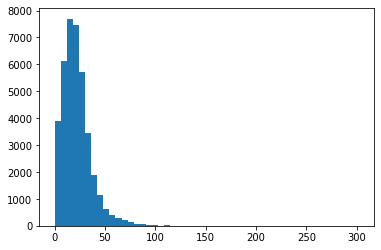

In [47]:
import matplotlib.pyplot as plt

plt.hist(counts, bins=50);
plt.show()

In [51]:
mean, stdev = np.mean(counts, axis=0), np.std(counts, axis=0)
print(mean)
print(stdev)

22.2157372039725
14.52754667121702


In [54]:
upper_quartile = np.percentile(counts, 75)
lower_quartile = np.percentile(counts, 25)
print(upper_quartile)
print(lower_quartile)

29.0
12.0


In [56]:
IQR = (upper_quartile - lower_quartile) * 1.5
print(IQR)

25.5


In [57]:
boundaries = (lower_quartile - IQR, upper_quartile + IQR)
print(boundaries)

(-13.5, 54.5)


In [60]:
len(tokenized_sentences)

39270

Remove Sentences that contain more than 55 tokens

In [ ]:
all_sentences = tokenized_sentences
tokenized_sentences = [] #Will store the selected sentences (#tokens>55)
[tokenized_sentences.append(sentence) for sentence in all_sentences if len(sentence) < 55]

In [63]:
len(all_sentences), len(tokenized_sentences)

(39270, 38008)

### Save Cleaned/ Tokenized Sentences

In [64]:
# Save tokenized sentences (before adding the <UNK> tag)
filename = os.path.join("output_data", "UNK 5-55/training_sentences.pkl")
with open(filename, "wb") as file: 
    pickle.dump(tokenized_sentences, file)

### Get List of Unknown Words

We are creating a list that contains unknown words that will be used later. We will consider Unknown words those that occur fewer than 2 times in the corpus.

In [65]:
# Obtain all tokens in a flat (1-dimensional) list
tokens = list(itertools.chain.from_iterable(tokenized_sentences))

In [66]:
from nltk.probability import FreqDist

freqDist = FreqDist(tokens)
unk_words = list(filter(lambda x: x[1]<=5, freqDist.items()))
unk_words_list = []
for element in unk_words:
    unk_words_list.append(element[0])

len(unk_words_list)

29400

### Export Unknown Words

In [67]:
def export_list(li, output_file):
    a_file = open(output_file, "wb")
    pickle.dump(li, a_file)
    a_file.close()

In [68]:
export_list(unk_words_list,"output_data/UNK 5-55/unknown_words.pkl")

In [69]:
len(unk_words_list)

29400

### Export Used Words

In [70]:
used_words = list(filter(lambda x: x[1]>1, freqDist.items()))
used_words_list = []
for element in used_words:
    used_words_list.append(element[0])

len(used_words_list)

22734

In [72]:
export_list(used_words_list,"output_data/UNK 5-55/used_words.pkl")

### Tag Unknown words

We will replace by \<UNK\> all the Uknown words defined earlier in the list unk_words_list.

In [73]:
tokenized_sentences_unk = []
for sentence in tokenized_sentences:
    l_replace_all = ['<UNK>' if word in unk_words_list else word for word in sentence]
    tokenized_sentences_unk.append(l_replace_all)

#tokenized_sentences_unk[0]

In [75]:
# Save training/test sentences with the <UNK> tags 
filename = os.path.join("output_data/UNK 5-55", "training_sentences_unk.pkl")
with open(filename, "wb") as file: 
    pickle.dump(tokenized_sentences_unk, file)

## Generate N-Grams

### Unigrams

For unigrams, we don't take into account the sentences, so we are just getting the single tokens and creating a dictionary

In [76]:
#Join elements of the list tokenized_sentences_unk (that contains each sentence unigrams) into a single list
unigrams = list(itertools.chain.from_iterable(tokenized_sentences_unk))
#unigrams

#### Generate Unigram Dictionary

In [77]:
unigrams_dict = FreqDist(unigrams)
unigrams_dict_top_20 = unigrams_dict.most_common(20)
print("Top 20 unigrams and frequency: \n", unigrams_dict_top_20)

Top 20 unigrams and frequency: 
 [('<UNK>', 52997), ('the', 50174), ('of', 23966), ('to', 20818), ('and', 18468), ('a', 17081), ('in', 16838), ('that', 8109), ('is', 8011), ('for', 7567), ('on', 5345), ('by', 5278), ('it', 4842), ('was', 4562), ('with', 4544), ('as', 4437), ('be', 4329), ('are', 4316), ('said', 4202), ('have', 3888)]


In [78]:
#Convert FreqDist to disctionary
unigrams_dict = dict(unigrams_dict)

# Add <s> and </s> tags to the unigram dict
num_sentences = len(tokenized_sentences_unk)
unigrams_dict['<s>'] = num_sentences
unigrams_dict['</s>'] = num_sentences

### Bigrams

#### Add Padding Symbols to Sentences

In [79]:
from nltk.util import pad_sequence

bi_tokens_padding = []

for sentence in tokenized_sentences_unk:
    e = list(pad_sequence(sentence,
                     pad_left=True, left_pad_symbol="<s>",
                     pad_right=True, right_pad_symbol="</s>",
                     n=2))
    bi_tokens_padding.append(e)

#bi_tokens_padding[0]

#### Generate Bigram Dictionary

In [80]:
bigrams = []
for sentence in bi_tokens_padding:
    bigrams.append(list(nltk.bigrams(sentence)))

#bigrams

In [81]:
#Join elements of the list bigrams (that contains each sentence bigrams) into a single list
bigrams = list(itertools.chain.from_iterable(bigrams))
#bigrams

In [82]:
bigrams_dict = FreqDist(bigrams)
bigrams_dict_top_20 = bigrams_dict.most_common(20)
print("Top 20 bigrams and frequency: \n", bigrams_dict_top_20)

Top 20 bigrams and frequency: 
 [(('<UNK>', '<UNK>'), 6117), (('of', 'the'), 6021), (('<s>', 'the'), 5908), (('the', '<UNK>'), 4739), (('in', 'the'), 4477), (('<UNK>', '</s>'), 4103), (('a', '<UNK>'), 2564), (('<UNK>', 'and'), 2550), (('and', '<UNK>'), 2115), (('to', 'the'), 2079), (('<UNK>', 'of'), 2028), (('of', '<UNK>'), 2021), (('<UNK>', 'the'), 1944), (('<s>', '<UNK>'), 1811), (('on', 'the'), 1588), (('to', '<UNK>'), 1524), (('<UNK>', 'in'), 1406), (('for', 'the'), 1395), (('<s>', 'but'), 1382), (('per', 'cent'), 1371)]


In [83]:
#Convert FreqDist to disctionary
bigrams_dict = dict(bigrams_dict)

# Add <s><s> and </s></s> bigrams to the bigram dict
num_sentences = len(tokenized_sentences_unk)
bigrams_dict[('<s>', '<s>')] = num_sentences
bigrams_dict[('</s>', '</s>')] = num_sentences
#bigrams_dict

### Trigrams

#### Add Padding Symbols to Sentences

In [84]:
tri_tokens_padding = []

for sentence in bi_tokens_padding:
    e = list(pad_sequence(sentence,
                     pad_left=True, left_pad_symbol="<s>",
                     pad_right=True, right_pad_symbol="</s>",
                     n=2))
    tri_tokens_padding.append(e)

#tri_tokens_padding[0]

#### Generate Trigram Dictionary

In [85]:
trigrams = []
for sentence in tri_tokens_padding:
    trigrams.append(list(nltk.trigrams(sentence)))

#trigrams[0]

In [86]:
#Join elements of the list trigrams (that contains each sentence trigrams) into a single list
trigrams = list(itertools.chain.from_iterable(trigrams))
#trigrams

In [87]:
trigrams_dict = FreqDist(trigrams)
trigrams_dict_top_20 = trigrams_dict.most_common(20)
print("Top 20 triigrams and frequency: \n", trigrams_dict_top_20)

Top 20 triigrams and frequency: 
 [(('<s>', '<s>', 'the'), 5908), (('<UNK>', '</s>', '</s>'), 4103), (('<s>', '<s>', '<UNK>'), 1811), (('<s>', '<s>', 'but'), 1382), (('<s>', '<s>', 'in'), 1351), (('said', '</s>', '</s>'), 1136), (('<s>', '<s>', 'it'), 1117), (('<UNK>', '<UNK>', '<UNK>'), 1037), (('<s>', '<s>', 'he'), 950), (('<s>', '<s>', 'mr'), 782), (('<s>', '<s>', 'a'), 703), (('<UNK>', 'and', '<UNK>'), 694), (('<s>', '<s>', 'they'), 585), (('the', '<UNK>', 'of'), 579), (('<s>', '<s>', 'this'), 577), (('of', 'the', '<UNK>'), 565), (('<UNK>', 'of', 'the'), 554), (('<s>', '<s>', 'industries'), 520), (('<s>', '<s>', 'types'), 520), (('per', 'cent', 'of'), 512)]


In [88]:
#Convert FreqDist to disctionary
trigrams_dict = dict(trigrams_dict)

# Add <s><s><s> and </s></s></s> trigrams to the trigram dict
num_sentences = len(tokenized_sentences_unk)
trigrams_dict[('<s>', '<s>', '<s>')] = num_sentences
trigrams_dict[('</s>', '</s>', '</s>')] = num_sentences

#trigrams_dict

### Four-grams

#### Add Padding Symbols to Sentences

In [89]:
four_tokens_padding = []

for sentence in tri_tokens_padding:
    e = list(pad_sequence(sentence,
                     pad_left=True, left_pad_symbol="<s>",
                     pad_right=True, right_pad_symbol="</s>",
                     n=2))
    four_tokens_padding.append(e)

#four_tokens_padding[0]

#### Generate Four-gram Dictionary

In [90]:
from nltk.util import ngrams

fourgrams = []
for sentence in four_tokens_padding:
    fourgrams.append( list(ngrams(sentence, 4)) )

#fourgrams[0]

In [91]:
#Join elements of the list fourgrams (that contains each sentence fourgrams) into a single list
fourgrams = list(itertools.chain.from_iterable(fourgrams))
#fourgrams

In [92]:
fourgrams_dict = FreqDist(fourgrams)
fourgrams_dict_top_20 = fourgrams_dict.most_common(20)
print("Top 20 fourgrams and frequency: \n", fourgrams_dict_top_20)

Top 20 fourgrams and frequency: 
 [(('<s>', '<s>', '<s>', 'the'), 5908), (('<UNK>', '</s>', '</s>', '</s>'), 4103), (('<s>', '<s>', '<s>', '<UNK>'), 1811), (('<s>', '<s>', '<s>', 'but'), 1382), (('<s>', '<s>', '<s>', 'in'), 1351), (('said', '</s>', '</s>', '</s>'), 1136), (('<s>', '<s>', '<s>', 'it'), 1117), (('<s>', '<s>', '<s>', 'he'), 950), (('<s>', '<s>', '<s>', 'mr'), 782), (('<s>', '<s>', '<s>', 'a'), 703), (('<s>', '<s>', '<s>', 'they'), 585), (('<s>', '<s>', '<s>', 'this'), 577), (('<s>', '<s>', '<s>', 'industries'), 520), (('<s>', '<s>', '<s>', 'types'), 520), (('<s>', '<s>', '<s>', 'we'), 496), (('<s>', '<s>', 'the', '<UNK>'), 479), (('?', '</s>', '</s>', '</s>'), 461), (('<UNK>', '<UNK>', '</s>', '</s>'), 446), (('<s>', '<s>', '<s>', 'i'), 437), (('<s>', '<s>', '<s>', 'there'), 407)]


In [93]:
#Convert FreqDist to disctionary
fourgrams_dict = dict(fourgrams_dict)
#fourgrams_dict

### Export N-Gram Dictionaries (in pkl files)

In [94]:
import pickle
output_folder = "output_data/UNK 5-55/"
unigram_dictionary_file = "unigram_dictionary_training.pkl"
bigram_dictionary_file = "bigram_dictionary_training.pkl"
trigram_dictionary_file = "trigram_dictionary_training.pkl"
fourgram_dictionary_file = "fourgram_dictionary_training.pkl"

In [95]:
def export_dictionary(dict, output_file):
    a_file = open(output_folder + output_file, "wb")
    pickle.dump(dict, a_file)
    a_file.close()

In [96]:
#Export dictionaries
export_dictionary(unigrams_dict, unigram_dictionary_file)
export_dictionary(bigrams_dict, bigram_dictionary_file)
export_dictionary(trigrams_dict, trigram_dictionary_file)
export_dictionary(fourgrams_dict, fourgram_dictionary_file)

### Explore N-Grams

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import operator

In [13]:
#Read dictionaries
data_folder = "output_data/UNK 5-55/"
unigram_pkl = "unigram_dictionary_training.pkl"
bigram_pkl = "bigram_dictionary_training.pkl"
trigram_pkl = "trigram_dictionary_training.pkl"
fourgram_pkl = "fourgram_dictionary_training.pkl"
training_sentences_unk="training_sentences_unk.pkl"

In [12]:
def load_pkl(folder, file):
    """Helper function to load a pkl file"""
    filename = os.path.join(folder, file)
    with open(filename, "rb") as file: 
        file_contents = pickle.load(file)
    return(file_contents)

In [80]:
unigram_dict = load_pkl(data_folder, unigram_pkl)
bigram_dict = load_pkl(data_folder, bigram_pkl)
trigram_dict = load_pkl(data_folder, trigram_pkl)
fourgram_dict = load_pkl(data_folder, fourgram_pkl)

### Top-10 Unigrams

<BarContainer object of 10 artists>

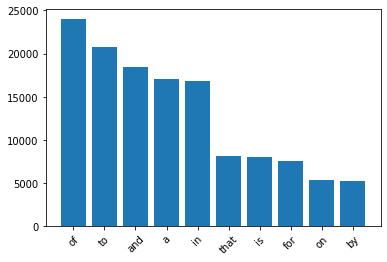

In [123]:
unigram_dict_top10 = dict(sorted(unigram_dict.items(), key=operator.itemgetter(1), reverse=True)[4:14])
plt.xticks(rotation=45)
plt.bar([ str(i) for i in unigram_dict_top10.keys() ], unigram_dict_top10.values())

### Top-10 Bigrams

<BarContainer object of 10 artists>

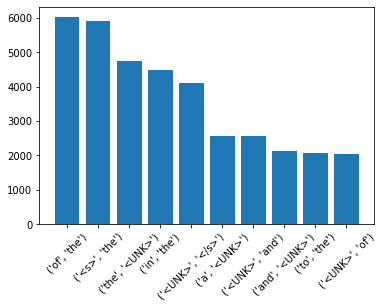

In [130]:
bigram_dict_top10 = dict(sorted(bigram_dict.items(), key=operator.itemgetter(1), reverse=True)[3:13])
plt.xticks(rotation=45)
plt.bar([ str(i) for i in bigram_dict_top10.keys() ], bigram_dict_top10.values())

### Top-10 Trigrams

<BarContainer object of 10 artists>

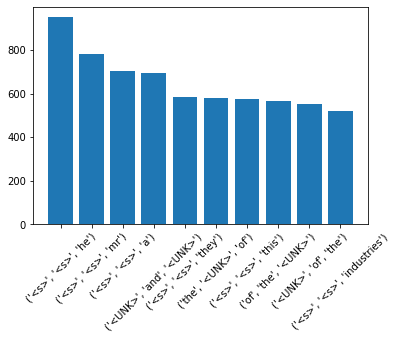

In [133]:
trigram_dict_top10 = dict(sorted(trigram_dict.items(), key=operator.itemgetter(1), reverse=True)[10:20])
plt.xticks(rotation=45)
plt.bar([ str(i) for i in trigram_dict_top10.keys() ], trigram_dict_top10.values())

### Top 10 Four-Ggams

<BarContainer object of 10 artists>

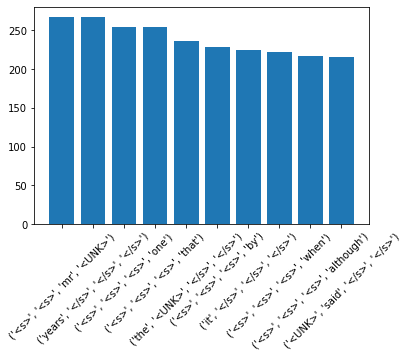

In [135]:
fourgram_dict_top10 = dict(sorted(fourgram_dict.items(), key=operator.itemgetter(1), reverse=True)[10:20])
plt.xticks(rotation=45)
plt.bar([ str(i) for i in fourgram_dict_top10.keys() ], fourgram_dict_top10.values())